# **CRAB Quickstart**

Goal: run a single CRAB optimization using the refactored `src/` workflows starting from the default baseline pulses.
Quickstart: edit the Parameter Panel, run all cells, then review the Results Summary.

Sections:
- [Parameter Panel](#Parameter-Panel)
- [Run Experiment](#Run-Experiment)
- [Standard Plots](#Standard-Plots)
- [Penalty History](#Penalty-History)
- [Results Summary](#Results-Summary)
- [Troubleshooting](#Troubleshooting)


## Imports


In [1]:
# Imports
from pathlib import Path
import json
import numpy as np
import sys, os


# Assume this notebook lives in project_root/notebooks/
notebook_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
repo_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
# Ensure local imports work when running the notebook outside vscode.
if str(repo_root) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

from src import (
    ExperimentConfig,
    override_from_dict,
    run_experiment,
    plot_cost_history,
    plot_pulses,
    plot_summary,
    plot_penalties_history,
    Result,
    TimeGridSpec,
    PulseShapeSpec,
    BasisSpec,
    GrapeBaselineConfig,
    build_grape_baseline,
)




/home/yehon/projects/grape-crab-qoc/src/plotting.py:239: SyntaxWarning: invalid escape sequence '\m'
  ax_delta.set_xlabel("Time ($\mu$s)")


##  what variables definitions the user sould input

In [2]:
# User-configurable parameters
# Time grid
"""Edit these dictionaries only."""
# Adjust optimizer tolerances if you want to force more iterations
time_grid = {
    "duration_us": 0.1,
    "num_points": 2001,
}

# Baseline pulse shapes 
omega_shape = {
    "kind": "polynomial", # options are: "polynomial" ,"gaussian", "sech", "blackman", "sine_bump"

    "area_pi": 1.0,
}
# Set to None to disable detuning optimisation
delta_shape = {
    "kind": "polynomial_chirp", # options are: "polynomial_chirp", "linear_chirp", "tanh_chirp", "zero"
    "area_pi": 0.0,
    "amplitude_scale": 40.0,
}

# Basis specification (number of harmonic modes)
basis_config = {
    "num_omega": 6,
    "num_delta": 3,
}

# Initial and target states
rho0 = np.array([[1.0, 0.0], [0.0, 0.0]], dtype=np.complex128)
target = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.complex128)




In [3]:
# Build deterministic baseline arrays from the parameters
_time_spec = TimeGridSpec(**time_grid)
_basis_spec = BasisSpec(**basis_config)
_omega_spec = PulseShapeSpec(**omega_shape)
_delta_spec = PulseShapeSpec(**delta_shape) if delta_shape is not None else None

baseline_config = GrapeBaselineConfig(
    time_grid=_time_spec,
    omega=_omega_spec,
    delta=_delta_spec,
    basis=_basis_spec,
    rho0=rho0,
    target=target,
    extra_metadata={"source": "quickstart_notebook"},
)

baseline_arrays, baseline_metadata = build_grape_baseline(baseline_config)
baseline_params = baseline_config.to_dict()
print("Baseline built: Nt =", int(baseline_arrays["Nt"]), "samples")



Baseline built: Nt = 2001 samples


In [4]:
# @title Parameter Panel
arrays = baseline_arrays
T_us = float(arrays["T"])
Nt = int(arrays["Nt"])
t_us = arrays["t"].astype(float)
omega0 = arrays["Omega0"].astype(float)
delta0 = arrays["Delta0"].astype(float)

frequencies_omega = arrays["omega_frequencies_rad_per_us"].tolist()
default_K = len(frequencies_omega)

omega_basis = arrays["CRAB_BASIS_OMEGA"]
delta_basis = arrays["CRAB_BASIS_DELTA"]

delta_max_rad_per_us = float(np.abs(delta0).max())
delta_max_MHz = delta_max_rad_per_us / (2 * np.pi)

user_params = {
    "run_name": None,
    "output_dir": "results/quickstart",
    "objective": "terminal",
    "time_grid": {"t0_us": float(t_us[0]), "t1_us": float(t_us[-1]), "M": Nt},
    "crab": {
        "K": default_K,
        "omegas_rad_per_us": frequencies_omega,
        "phases": [0.0] * default_K,
        "use_delta": delta_basis.shape[1] > 0,
    },
    "weights": {"w_power": 1.0e-4, "w_neg": 1.0, "neg_kappa": 10.0},
    "optimizer": {
        "method": "adam",
        "max_iters": 2000,
        "learning_rate": 0.05,
        "beta1": 0.9,
        "beta2": 0.999,
        "epsilon": 1e-8,
        "grad_clip": None,
        "grad_tol": 1e-7,
        "rtol": 1e-7,
    },
    "path": {"reference": "adiabatic_ground_state"},
    "ensemble": {
        "beta_min": 0.9,
        "beta_max": 1.1,
        "num_beta": 5,
        "detuning_MHz_min": -0.1 * delta_max_MHz,
        "detuning_MHz_max": 0.1 * delta_max_MHz,
        "num_detuning": 5,
    },
}

overrides = {
    "baseline": {"name": "notebook", "params": baseline_params},
    "run_name": user_params["run_name"],
    "artifacts_root": str(Path(user_params["output_dir"]).resolve()),
    "optimizer_options": {
        "method": user_params["optimizer"]["method"],
        "max_iters": int(user_params["optimizer"]["max_iters"]),
        "learning_rate": float(user_params["optimizer"]["learning_rate"]),
        "beta1": float(user_params["optimizer"]["beta1"]),
        "beta2": float(user_params["optimizer"]["beta2"]),
        "epsilon": float(user_params["optimizer"]["epsilon"]),
        "grad_clip": user_params["optimizer"]["grad_clip"],
        "grad_tol": float(user_params["optimizer"]["grad_tol"]),
        "rtol": float(user_params["optimizer"]["rtol"]),
        "optimize_delta": bool(user_params["crab"]["use_delta"]),
        "K": int(user_params["crab"]["K"]),
        "omegas_rad_per_us": user_params["crab"]["omegas_rad_per_us"],
        "phases": user_params["crab"]["phases"],
    },
    "penalties": {
        "power_weight": float(user_params["weights"]["w_power"]),
        "neg_weight": float(user_params["weights"]["w_neg"]),
        "neg_kappa": float(user_params["weights"]["neg_kappa"]),
    },
    "metadata": {
        "objective": user_params["objective"],
        "path_params": user_params["path"],
        "ensemble_params": user_params["ensemble"],
        "baseline_metadata": baseline_metadata,
    },
}

cfg = override_from_dict(ExperimentConfig(), overrides)
cfg.metadata["delta_max_rad_per_us"] = delta_max_rad_per_us

print("Parameter summary:")
summary_rows = [
    ("objective", user_params["objective"]),
    ("method", user_params["optimizer"]["method"]),
    ("max_iters", user_params["optimizer"]["max_iters"]),
    ("learning_rate", user_params["optimizer"]["learning_rate"]),
    ("grad_clip", user_params["optimizer"]["grad_clip"]),
    ("grad_tol", user_params["optimizer"]["grad_tol"]),
    ("rtol", user_params["optimizer"]["rtol"]),
    ("K", user_params["crab"]["K"]),
    ("use_delta", user_params["crab"]["use_delta"]),
    ("w_power", user_params["weights"]["w_power"]),
    ("w_neg", user_params["weights"]["w_neg"]),
]
for name, value in summary_rows:
    print(f"  {name:>15}: {value}")


def _json_default(obj):
    if isinstance(obj, complex):
        return {"real": obj.real, "imag": obj.imag}
    if hasattr(obj, "tolist"):
        return obj.tolist()
    return str(obj)
print(json.dumps(cfg.to_dict(), indent=2, default=_json_default))
# cfg


Parameter summary:
        objective: terminal
           method: adam
        max_iters: 2000
    learning_rate: 0.05
        grad_clip: None
         grad_tol: 1e-07
             rtol: 1e-07
                K: 6
        use_delta: True
          w_power: 0.0001
            w_neg: 1.0
{
  "baseline": {
    "name": "notebook",
    "params": {
      "time_grid": {
        "duration_us": 0.1,
        "num_points": 2001,
        "start_us": 0.0
      },
      "omega": {
        "kind": "polynomial",
        "area_pi": 1.0,
        "amplitude_scale": null,
        "options": {}
      },
      "basis": {
        "num_omega": 6,
        "num_delta": 3,
        "omega_harmonics": null,
        "delta_harmonics": null
      },
      "rho0": [
        [
          {
            "real": 1.0,
            "imag": 0.0
          },
          {
            "real": 0.0,
            "imag": 0.0
          }
        ],
        [
          {
            "real": 0.0,
            "imag": 0.0
          },
   

## Run Experiment


In [5]:
# @title Run Experiment {display-mode: "code"}
result: Result = run_experiment(cfg, method=user_params['optimizer']['method'])
#result


## Standard Plots


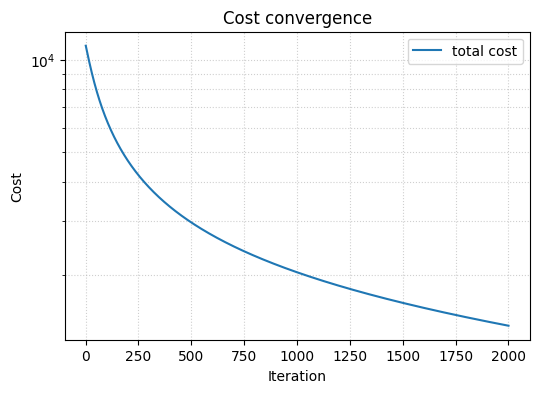

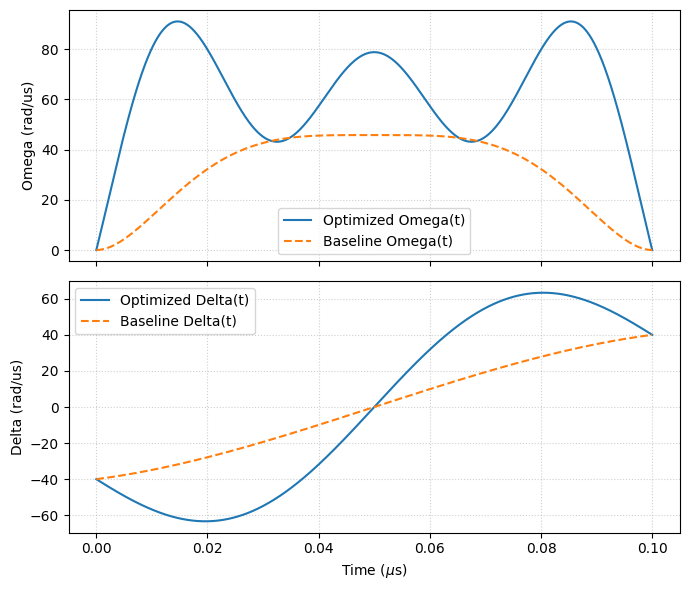

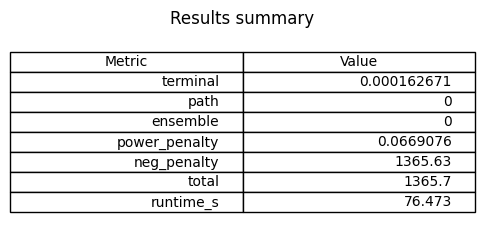

In [6]:
# @title Standard Plots
_ = plot_cost_history(result)
_ = plot_pulses(result)
_ = plot_summary(result)


## Penalty History


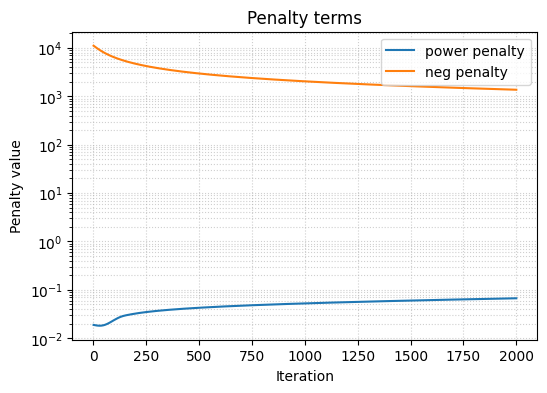

In [7]:
# @title Penalty History
_ = plot_penalties_history(result)


## Results Summary


In [ ]:
# @title Results Summary
from pathlib import Path

metrics_table = {
    'terminal_infidelity': result.final_metrics.get('terminal'),
    'path_infidelity': result.final_metrics.get('path'),
    'ensemble_infidelity': result.final_metrics.get('ensemble'),
    'power_penalty': result.final_metrics.get('power_penalty'),
    'neg_penalty': result.final_metrics.get('neg_penalty'),
    'total_cost': result.final_metrics.get('total'),
    'runtime_seconds': result.final_metrics.get('runtime_s'),
}
print('Final metrics:')
for key, value in metrics_table.items():
    if value is not None:
        print(f"  {key:>20}: {value:.6g}")
    else:
        print(f"  {key:>20}: n/a")

print('\nArtifacts saved in', result.artifacts_dir)
for artifact in sorted(Path(result.artifacts_dir).iterdir()):
    print(' -', artifact.name)


Final metrics:
   terminal_infidelity: 0.000162671
       path_infidelity: 0
   ensemble_infidelity: 0
         power_penalty: 0.0669076
           neg_penalty: 1365.63
            total_cost: 1365.7
       runtime_seconds: 76.473

Artifacts saved in /home/yehon/projects/grape-crab-qoc/results/quickstart/adam-notebook-20251015-213454
 - config.json
 - figures
 - history.npz
 - logs.txt
 - metrics.json
 - pulses.npz


: 

## Troubleshooting

- Learning rate too aggressive? Decrease `learning_rate` (Adam/const) or `alpha0` (line-search).
- Cost plateaus early? Raise `max_iters` or relax penalty weights.
- Armijo fails repeatedly? Tune `ls_beta` (0.3-0.7) and `ls_sigma` (1e-4-1e-2).
- Negativity penalty dominates? Reduce `w_neg` or increase `neg_kappa`.
- Basis too restrictive? Increase `K` or provide custom `omegas_rad_per_us`/`phases`.
- Detuning updates unstable? Set `use_delta` to `False` to keep the baseline detuning.
- Ensemble sweeps slow? Trim `num_beta` / `num_detuning` or enable `grad_clip`.
- Large artifacts folder? Change `output_dir` or reuse an existing `run_name`.
